In [8]:
import requests
from bs4 import BeautifulSoup
from bs4.element import Tag
import re
from datetime import datetime, time, timedelta
import locale
import pandas as pd

In [60]:
pd.set_option('display.max_colwidth', 100)

In [39]:
threads = [
    "https://forum.animewolken.nl/showthread.php?t=56475",
    "https://forum.animewolken.nl/showthread.php?t=58027",
    "https://forum.animewolken.nl/showthread.php?t=58164",
    "https://forum.animewolken.nl/showthread.php?t=59241",
    "https://forum.animewolken.nl/showthread.php?t=59255",
    "https://forum.animewolken.nl/showthread.php?t=59898",
    "https://forum.animewolken.nl/showthread.php?t=60747",
    "https://forum.animewolken.nl/showthread.php?t=61928",
    "https://forum.animewolken.nl/showthread.php?t=62944",
    "https://forum.animewolken.nl/showthread.php?t=63892",
    "https://forum.animewolken.nl/showthread.php?t=64291",
    "https://forum.animewolken.nl/showthread.php?t=64891",
    "https://forum.animewolken.nl/showthread.php?t=65465",
    "https://forum.animewolken.nl/showthread.php?t=65732",
    "https://forum.animewolken.nl/showthread.php?t=69781",
    "https://forum.animewolken.nl/showthread.php?t=69794",
    "https://forum.animewolken.nl/showthread.php?t=70235",
    "https://forum.animewolken.nl/showthread.php?t=70577",
    "https://forum.animewolken.nl/showthread.php?t=70824",
    "https://forum.animewolken.nl/showthread.php?t=70983",
    "https://forum.animewolken.nl/showthread.php?t=70985",
    "https://forum.animewolken.nl/showthread.php?t=71184",
    "https://forum.animewolken.nl/showthread.php?t=71420",
    "https://forum.animewolken.nl/showthread.php?t=71717",
    "https://forum.animewolken.nl/showthread.php?t=71976",
    "https://forum.animewolken.nl/showthread.php?t=72187",
    "https://forum.animewolken.nl/showthread.php?t=72261",
    "https://forum.animewolken.nl/showthread.php?t=72424",
    "https://forum.animewolken.nl/showthread.php?t=72426",
    "https://forum.animewolken.nl/showthread.php?t=72657",
    "https://forum.animewolken.nl/showthread.php?t=72781",
    "https://forum.animewolken.nl/showthread.php?t=72972",
    "https://forum.animewolken.nl/showthread.php?t=73163",
    "https://forum.animewolken.nl/showthread.php?t=73169",
    "https://forum.animewolken.nl/showthread.php?t=73340",
    "https://forum.animewolken.nl/showthread.php?t=73515",
    "https://forum.animewolken.nl/showthread.php?t=73657",
    "https://forum.animewolken.nl/showthread.php?t=73827",
    "https://forum.animewolken.nl/showthread.php?t=73930",
    "https://forum.animewolken.nl/showthread.php?t=74093",
    "https://forum.animewolken.nl/showthread.php?t=74215",
    "https://forum.animewolken.nl/showthread.php?t=74333",
    "https://forum.animewolken.nl/showthread.php?t=74401",
    "https://forum.animewolken.nl/showthread.php?t=74510",
    "https://forum.animewolken.nl/showthread.php?t=74634",
    "https://forum.animewolken.nl/showthread.php?t=74728",
    "https://forum.animewolken.nl/showthread.php?t=74729",
    "https://forum.animewolken.nl/showthread.php?t=74816",
    "https://forum.animewolken.nl/showthread.php?t=75342",
    "https://forum.animewolken.nl/showthread.php?t=75573",
    "https://forum.animewolken.nl/showthread.php?t=75750",
    "https://forum.animewolken.nl/showthread.php?t=75800",
    "https://forum.animewolken.nl/showthread.php?t=75861",
    "https://forum.animewolken.nl/showthread.php?t=75890"
]

In [40]:
def getHtml(threadUrl: str):
    try:
        r = requests.get(threadUrl)
    except requests.exceptions.RequestException:
        print(f"Invalid url: {threadUrl}")
        return None
    
    return r.text

In [41]:
def getPosts(page: BeautifulSoup):
    return page.find_all("div", attrs={"class": "Oudwindowbg2"})


In [48]:
postDateTimePattern = re.compile("geplaatst op\s+(\d+ \w+ \d+ @ \d+:\d+)")
editDateTimePattern = re.compile("\[\s+Laatst gewijzigd door .+; (\d+ .+ \d+ om \d+:\d+)\s+(.+\s+)?\]")
locale.setlocale(locale.LC_TIME, "nl_NL")

def getPostsAndDates(pageUrl: str):
    def matchReGetFirst(string, pattern):
        match = pattern.match(string)
        if match is None:
            raise Exception(f"No match for string \"{string}\"")
        
        return match.group(1)
    
    html = getHtml(pageUrl)
    if html is None:
        raise Exception(f"Couldn't retrieve HTML for url {pageUrl}")
    page = BeautifulSoup(html, 'html.parser')
    
    results = []
    ps = page.find_all("div", attrs={"class": "vb_postbit"})
    print("posts on this page:", len(ps))
    for post in ps:
        user = post.parent.parent.find("a", attrs={"class": "bigusername"}).text
        postText = post.parent.find("div", attrs={"class": "smallfont", "style": "float:left"}).text.strip()
        
        ems = post.parent.find_all("em")
        editText = None
        if len(ems) > 0:
            editText = ems[-1].text
                
        postDateTimeString = matchReGetFirst(postText, postDateTimePattern)
        postDateTime = datetime.strptime(postDateTimeString, "%d %B %Y @ %H:%M")
    
        editDateTime = None    
        if editText is not None:
            editDateTimeString =  matchReGetFirst(editText, editDateTimePattern)
            editDateTime = datetime.strptime(editDateTimeString, "%d %B %Y om %H:%M")
        
        results.append((user, postDateTime, editDateTime, pageUrl))
    
    return results

In [49]:
n_max_pages = 16
def getPageUrls(threadUrl: str):
    for i in range(1, n_max_pages + 1):
        if i == 1:
            yield threadUrl
        else:
            yield threadUrl + f"&page={i}"


def getPosterAndDateByThreadUrl(threadUrl: str):
    posts = []
    for i, pageUrl in enumerate(getPageUrls(threadUrl)):
        print(f"{i+1}/{n_max_pages}) Scanning page {pageUrl}")

        result = getPostsAndDates(pageUrl)
        posts.extend(result)
        
        if len(result) != 15:
            # Page is not entirely filled, completely retrieved thread
            break
    
    print("Total number of posts:", len(posts))
    
    return posts
    

In [50]:
pNd = []
for i, t in enumerate(threads):
    print(f"Thread {i+1}/{len(threads)}")
    pNd.extend(getPosterAndDateByThreadUrl(t))

Thread 1/54
1/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475
posts on this page: 15
2/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=2
posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=56475&page

posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/showthread.php?t=60747&page=13
posts on this page: 15
14/16) Scanning page https://forum.animewolken.nl/showthread.php?t=60747&page=14
posts on this page: 15
15/16) Scanning page https://forum.animewolken.nl/showthread.php?t=60747&page=15
posts on this page: 15
16/16) Scanning page https://forum.animewolken.nl/showthread.php?t=60747&page=16
posts on this page: 12
Total number of posts: 237
Thread 8/54
1/16) Scanning page https://forum.animewolken.nl/showthread.php?t=61928
posts on this page: 15
2/16) Scanning page https://forum.animewolken.nl/showthread.php?t=61928&page=2
posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=61928&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=61928&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=61928&page=5
posts on this page: 15
6/16) Scanning page

posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=65465&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showt

posts on this page: 15
15/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70577&page=15
posts on this page: 15
16/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70577&page=16
posts on this page: 14
Total number of posts: 239
Thread 19/54
1/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824
posts on this page: 15
2/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=2
posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=70824&page=7
posts on this page: 15
8/16) Scanning page ht

posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71717&page=12
posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71717&page=13
posts on this page: 15
14/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71717&page=14
posts on this page: 15
15/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71717&page=15
posts on this page: 15
16/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71717&page=16
posts on this page: 14
Total number of posts: 239
Thread 25/54
1/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71976
posts on this page: 15
2/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71976&page=2
posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71976&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=71976&page=4
posts on this page: 15
5/16) Scanning p

posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=12
posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=13
posts on this page: 15
14/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=14
posts on this page: 15
15/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=15
posts on this page: 15
16/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72657&page=16
posts on this page: 14
Total number of posts: 239
Thread 31/54
1/16) Scanning page https://forum.animewolken.nl/showthread.php?t=72781
posts on this page: 15
2/16) Scanni

posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=12
posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=13
posts on this page: 15
14/16) Scanning page https://forum.animewolken.nl/showthread.php?t=73515&page=14
posts on this page: 15
15/16) Scanning page https://forum.animewolken.nl

posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=12
posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74215&page=13
posts on this page: 15
14/16) Scanning page https://forum.animewolken.nl/s

posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showthread.php?t=74728&page=12
posts on this page: 15
13/16) Scanning page https://forum.animewolken.nl/sho

posts on this page: 15
3/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=3
posts on this page: 15
4/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=4
posts on this page: 15
5/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=5
posts on this page: 15
6/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=6
posts on this page: 15
7/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=7
posts on this page: 15
8/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=8
posts on this page: 15
9/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=9
posts on this page: 15
10/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=10
posts on this page: 15
11/16) Scanning page https://forum.animewolken.nl/showthread.php?t=75750&page=11
posts on this page: 15
12/16) Scanning page https://forum.animewolken.nl/showt

In [51]:
len(pNd)

11334

In [52]:
pNd[:10]

[('RobinotX',
  datetime.datetime(2009, 9, 5, 2, 38),
  datetime.datetime(2009, 9, 8, 7, 15),
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('RobinotX',
  datetime.datetime(2009, 9, 5, 2, 39),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Cursed_snorlax',
  datetime.datetime(2009, 9, 5, 2, 40),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Aoi',
  datetime.datetime(2009, 9, 5, 2, 51),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Nakao',
  datetime.datetime(2009, 9, 5, 2, 55),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Aoi',
  datetime.datetime(2009, 9, 5, 2, 57),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Nakao',
  datetime.datetime(2009, 9, 5, 2, 59),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Aoi',
  datetime.datetime(2009, 9, 5, 3, 4),
  None,
  'https://forum.animewolken.nl/showthread.php?t=56475'),
 ('Angelo',
  datetime.d

In [61]:
df = pd.DataFrame(pNd, columns=["poster", "postDateTime", "editDateTime", "pageUrl"])
df

,poster,postDateTime,editDateTime,pageUrl
0,RobinotX,2009-09-05 02:38:00,2009-09-08 07:15:00,https://forum.animewolken.nl/showthread.php?t=56475
1,RobinotX,2009-09-05 02:39:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
2,Cursed_snorlax,2009-09-05 02:40:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
3,Aoi,2009-09-05 02:51:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
4,Nakao,2009-09-05 02:55:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
...,...,...,...,...
11329,Lucario_Rocks!,2021-01-17 02:34:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11330,jurgyy,2021-02-20 03:36:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11331,Lucario_Rocks!,2021-02-20 03:37:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11332,lugia07,2021-02-22 04:04:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10


In [62]:
df.to_csv("./bikkels.csv", index=False)

In [258]:
df = pd.read_csv("./bikkels.csv", parse_dates=["postDateTime", "editDateTime"])
df

,poster,postDateTime,editDateTime,pageUrl
0,RobinotX,2009-09-05 02:38:00,2009-09-08 07:15:00,https://forum.animewolken.nl/showthread.php?t=56475
1,RobinotX,2009-09-05 02:39:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
2,Cursed_snorlax,2009-09-05 02:40:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
3,Aoi,2009-09-05 02:51:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
4,Nakao,2009-09-05 02:55:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475
...,...,...,...,...
11329,Lucario_Rocks!,2021-01-17 02:34:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11330,jurgyy,2021-02-20 03:36:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11331,Lucario_Rocks!,2021-02-20 03:37:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10
11332,lugia07,2021-02-22 04:04:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10


In [272]:
lowerBound = time(2, 25)
upperBound = time(6,  5)

def GetBikkelDateAndTime(postDateTime, editDateTime):
    if (lowerBound <= postDateTime.time() <= upperBound):
        return postDateTime.date(), postDateTime.time()
    if (not pd.isnull(editDateTime) and lowerBound <= editDateTime.time() <= upperBound):
        return editDateTime.date(), editDateTime.time()
    else:
        return pd.NaT, pd.NaT


df[["bikkelDate", "bikkelTime"]] = df.apply(lambda s: pd.Series(GetBikkelDateAndTime(s["postDateTime"], s["editDateTime"])), axis=1)
df


C:\Users\Jurgen\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,poster,postDateTime,editDateTime,pageUrl,bikkelDate,bikkelTime,isBikkel
0,RobinotX,2009-09-05 02:38:00,2009-09-08 07:15:00,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:38:00,True
2,Cursed_snorlax,2009-09-05 02:40:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:40:00,True
3,Aoi,2009-09-05 02:51:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:51:00,True
4,Nakao,2009-09-05 02:55:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:55:00,True
8,Angelo,2009-09-05 03:06:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,03:06:00,True
...,...,...,...,...,...,...,...
11328,Lucario_Rocks!,2021-01-15 02:33:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-15,02:33:00,True
11329,Lucario_Rocks!,2021-01-17 02:34:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-17,02:34:00,True
11331,Lucario_Rocks!,2021-02-20 03:37:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-20,03:37:00,True
11332,lugia07,2021-02-22 04:04:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-22,04:04:00,True


In [273]:
df["isBikkel"] = ~pd.isnull(df["bikkelDate"])
df = df[df["isBikkel"] == True]
df

C:\Users\Jurgen\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,poster,postDateTime,editDateTime,pageUrl,bikkelDate,bikkelTime,isBikkel
0,RobinotX,2009-09-05 02:38:00,2009-09-08 07:15:00,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:38:00,True
2,Cursed_snorlax,2009-09-05 02:40:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:40:00,True
3,Aoi,2009-09-05 02:51:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:51:00,True
4,Nakao,2009-09-05 02:55:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:55:00,True
8,Angelo,2009-09-05 03:06:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,03:06:00,True
...,...,...,...,...,...,...,...
11328,Lucario_Rocks!,2021-01-15 02:33:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-15,02:33:00,True
11329,Lucario_Rocks!,2021-01-17 02:34:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-17,02:34:00,True
11331,Lucario_Rocks!,2021-02-20 03:37:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-20,03:37:00,True
11332,lugia07,2021-02-22 04:04:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-22,04:04:00,True


In [274]:
df = df.drop_duplicates(subset=["poster", "bikkelDate"])
df

,poster,postDateTime,editDateTime,pageUrl,bikkelDate,bikkelTime,isBikkel
0,RobinotX,2009-09-05 02:38:00,2009-09-08 07:15:00,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:38:00,True
2,Cursed_snorlax,2009-09-05 02:40:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:40:00,True
3,Aoi,2009-09-05 02:51:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:51:00,True
4,Nakao,2009-09-05 02:55:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,02:55:00,True
8,Angelo,2009-09-05 03:06:00,NaT,https://forum.animewolken.nl/showthread.php?t=56475,2009-09-05,03:06:00,True
...,...,...,...,...,...,...,...
11328,Lucario_Rocks!,2021-01-15 02:33:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-15,02:33:00,True
11329,Lucario_Rocks!,2021-01-17 02:34:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-01-17,02:34:00,True
11331,Lucario_Rocks!,2021-02-20 03:37:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-20,03:37:00,True
11332,lugia07,2021-02-22 04:04:00,NaT,https://forum.animewolken.nl/showthread.php?t=75890&page=10,2021-02-22,04:04:00,True


In [275]:
posterFrequency = df["poster"].value_counts()
posterFrequency

Viral              822
Lucario_Rocks!     651
Jari               629
jurgyy             578
Legato             525
Cobpyth            472
Devian             349
Hardcore Kidd      292
Chopstick          287
Tsumemage          266
Audax              261
Goðafoss           255
Otani              253
Peanut             250
Dregora            241
lugia07            233
Airclever          230
Aerival            190
Lin                166
Sala               161
Croon              155
Ichiro Kazuki      128
Thijs.             123
Natsuki            122
Killax             114
Killerbee          105
RobinotX           102
Anime is kawaii    101
hentai-free         99
Gerard_Joling       84
Saki                79
N3TM@SK             77
Saskia              72
Num                 67
YC2009              67
Maverick            66
Kocur               60
Minato              58
sleipnir            54
Kast                53
tzimho              50
Wyrin               50
T. Tapes            50
KawaiiLanda

In [276]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

%matplotlib inline

In [277]:
first = min(df["bikkelDate"])
last = max(df["bikkelDate"])

firstMonth = np.datetime64(str(first.year) + "-" + "%02d" % first.month)
lastMonth = np.datetime64(str(last.year) + "-" + "%02d" % last.month)

In [278]:
x = np.arange(firstMonth, lastMonth, np.timedelta64(1, "M"), dtype="datetime64[M]")

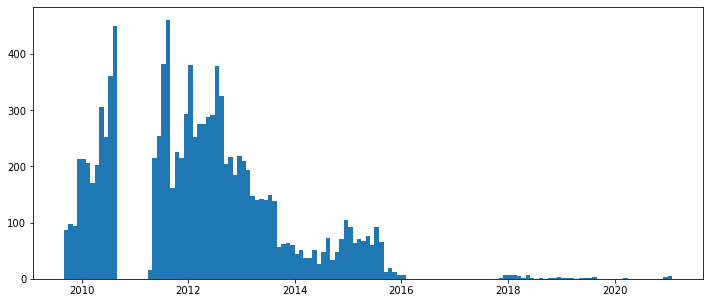

In [285]:
f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(111)
ax.hist(df["bikkelDate"], x)
plt.show()

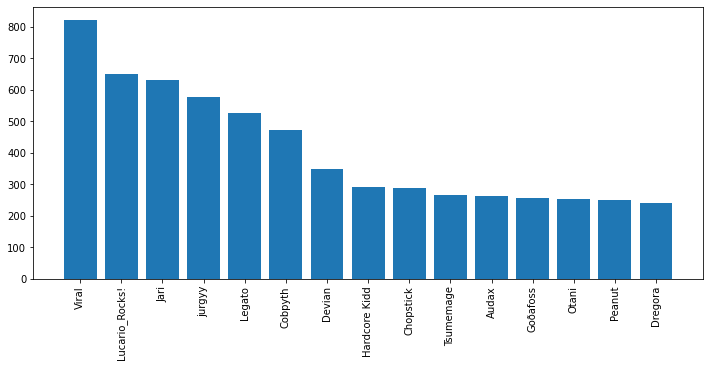

In [283]:
subset = posterFrequency[:15]

f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(111)
ax.bar(range(len(subset)), subset.values, tick_label=subset.index)
plt.xticks(rotation=90)
plt.show()

quarter
1900-01-01 02:15:00     101
1900-01-01 02:30:00    4728
1900-01-01 02:45:00    1891
1900-01-01 03:00:00    1172
1900-01-01 03:15:00     802
1900-01-01 03:30:00     595
1900-01-01 03:45:00     418
1900-01-01 04:00:00     305
1900-01-01 04:15:00     239
1900-01-01 04:30:00     213
1900-01-01 04:45:00     172
1900-01-01 05:00:00     117
1900-01-01 05:15:00     100
1900-01-01 05:30:00      74
1900-01-01 05:45:00      83
1900-01-01 06:00:00       8
Freq: 15T, Name: quarter, dtype: int64

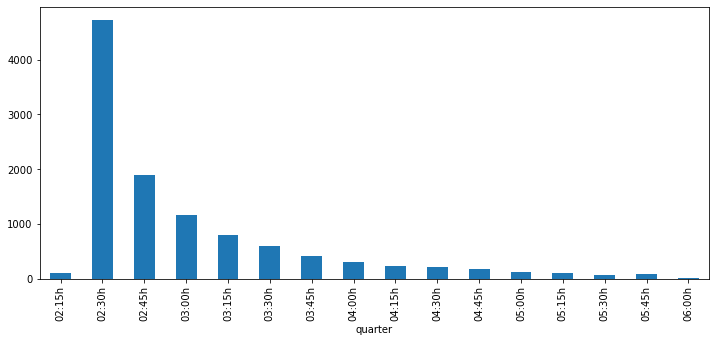

In [284]:
dg = df.copy()
dg["quarter"] = pd.to_datetime(dg["bikkelTime"],format='%H:%M:%S')
dg = dg.set_index("quarter", drop=False)
hourGroups = dg["quarter"].groupby(pd.Grouper(freq="15Min")).count()
display(hourGroups)

ax = hourGroups.plot(kind='bar', figsize=(12, 5))
ticklabels = hourGroups.index.strftime('%H:%Mh')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.show()